In [774]:
import pandas as pd
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

import optuna

import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [833]:
#read the automatic monitor measurement data in 2016

data = pd.read_csv('D:/Ozon_ML/Listv_2016_ozon.txt',
                        sep='	',
                        skip_blank_lines=True, 
                        names=['date','time','ppb']
                      )# parse_dates=[0,1]

In [834]:
data = data.drop(index=[21134,21135,21136,28363,28364,28365,28366,70194,70195,70196,83220,84065,84081,84082,84087])

<class 'pandas.core.frame.DataFrame'>
Index: 84287 entries, 0 to 84301
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    84287 non-null  datetime64[ns]
 1   time    84287 non-null  object        
 2   ppb     82627 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84287 entries, 2016-01-01 00:02:00 to 2016-12-05 13:41:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppb     84287 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1176 entries, 2016-01-01 00:00:00 to 2016-12-05 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppb     1176 non-null   float64
dtypes: float64(1)
memory usage: 18.4 KB
ppb6H No

<Axes: xlabel='date'>

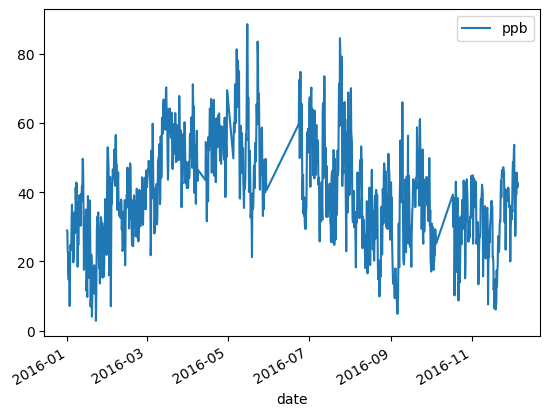

In [835]:
data['date'] = data['date'].astype('str').apply(lambda x: x[:-3])
data['date'] = data['date'].astype('str').apply(lambda x: x.replace('.','/'))
data['date'] = data['date'].astype('str').apply(lambda x: x+'/2016')
data['date'] = data['date'] + ' ' + data['time']
data['date'] = pd.to_datetime(data['date'],format='%m/%d/%Y %H:%M')
print(data.info())

data.loc[data['ppb']<0,'ppb'] = abs(data.loc[data['ppb']<0,'ppb'])
ppb=pd.DataFrame(data['ppb']).set_index(data['date'])
ppb = ppb.interpolate(columns=['ppb']) # fill Nan
print(ppb.info())

# resample automatic monitor data to 6 hours time resolution
ppb6H = ppb.resample('6H').mean().dropna()
print('ppb6H' ,ppb6H.info())

ppb6H.plot()

In [837]:
ppb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84287 entries, 2016-01-01 00:02:00 to 2016-12-05 13:41:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppb     84287 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


In [839]:
ppb6H.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1176 entries, 2016-01-01 00:00:00 to 2016-12-05 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppb     1176 non-null   float64
dtypes: float64(1)
memory usage: 18.4 KB


In [842]:
#read the data from reanalysis files 

file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2016_sin1.nc','r')

sp=np.array(file2read.variables['sp']) # surface pressure

sp = sp[:,0,0]

sd=np.array(file2read.variables['sd']) # snow depth
sd = sd[:,0,0]

file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2016_pres2.nc','r')

print(file2read.variables.keys())

cc = np.array(file2read.variables['cc'])[:,0,0] # cloud cover

file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2016_pres1.nc','r')

print(file2read.variables.keys())

o3 = np.array(file2read.variables['o3'])[:,0,0] # reanalysis ozone

r = np.array(file2read.variables['r'])[:,0,0] # relative humidity

t = np.array(file2read.variables['t'])[:,0,0] # temperature

u = np.array(file2read.variables['u'])[:,0,0] # surface wind u- component

v = np.array(file2read.variables['v'])[:,0,0] # surface wind v- component

o3_ppb = 28.9644 / 47.9982 * 1e9 * o3

file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2016_rad.nc','r')

ssrc = np.array(file2read.variables['ssrc'])[:,0,0] # solar radiation
fdir = np.array(file2read.variables['fdir'])[:,0,0] # solar radiation

dict_keys(['longitude', 'latitude', 'time', 'cc'])
dict_keys(['longitude', 'latitude', 'time', 'o3', 'r', 't', 'u', 'v'])


In [843]:
file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2016_veg.nc','r')
print(file2read.variables.keys())

dict_keys(['longitude', 'latitude', 'time', 'lai_lv', 'lai_hv'])


In [844]:
lai_hv = np.array(file2read.variables['lai_hv'])[:,0,0] # high vegetation leaf area index

lai_lv = np.array(file2read.variables['lai_lv'])[:,0,0] # low vegetation leaf area index

In [847]:
era5_time = np.array(file2read.variables['time'])

time = pd.to_datetime("1900-01-01")+pd.to_timedelta(era5_time, unit="H")
hours = era5_time

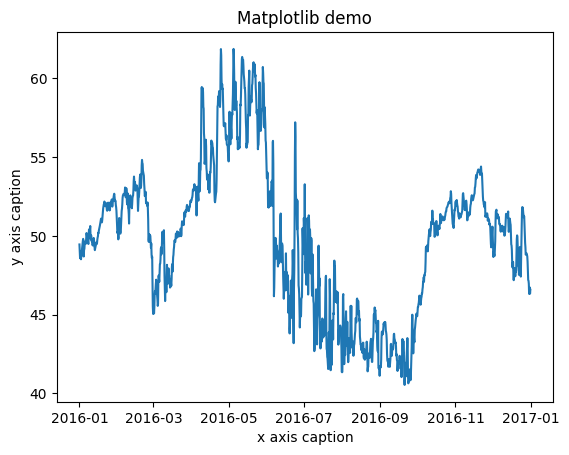

In [848]:
#ERA5 ozone timeseries

plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(time, o3_ppb) 
plt.show()

ppb4H vs o3_ppb

In [849]:
#select the records in measurement data
o3_ppb = o3_ppb[time.isin(ppb6H.index)]
sp = sp[time.isin(ppb6H.index)]
sd = sd[time.isin(ppb6H.index)]
#cc = cc[time.isin(ppb6H.index)]
r = r[time.isin(ppb6H.index)]
t = t[time.isin(ppb6H.index)]
u = u[time.isin(ppb6H.index)]
v = v[time.isin(ppb6H.index)]
hours = hours[time.isin(ppb6H.index)]
ssrc = ssrc[time.isin(ppb6H.index)]
fdir = fdir[time.isin(ppb6H.index)]
# hours00 = hours00[time.isin(ppb6H.index)]
# hours06 = hours06[time.isin(ppb6H.index)]
# hours12 = hours12[time.isin(ppb6H.index)]
#hours18 = hours18[time.isin(ppb6H.index)]
lai_hv = lai_hv[time.isin(ppb6H.index)]
lai_lv = lai_lv[time.isin(ppb6H.index)]

In [850]:
#wind angle
wa = u/v

# snow indicator
sd_ind = np.zeros(len(sd))
sd_ind[sd>0] = 1

In [852]:
#create features

features = pd.DataFrame(o3_ppb)
features['sp'] = sp
features['sd'] = sd
#features['cc'] = cc
features['r'] = r
features['t'] = t
features['u'] = u
features['v'] = v
features['wa'] = wa
#features['sd_ind'] = sd_ind
features['o3_ppb'] = o3_ppb
# features['hours00'] = hours00
# features['hours06'] = hours06
# features['hours12'] = hours12
# features['hours18'] = hours18
#features['hours_delta'] = abs(pd.Series(hours).shift(1).bfill()-pd.Series(hours))#hours
features['ssrc'] = ssrc
#features['lai_lv'] = lai_lv
features['lai_hv'] = lai_hv
#features['fdir'] = fdir
features['w_spd'] = (u**2 +v**2)**0.5
#features['wtg'] = wtg
features['month'] = pd.Series(ppb6H.index).dt.month
#features['week'] = pd.Series(ppb6H.index).dt.strftime('%U')


In [856]:
features = features.drop(0,axis=1)
target = ppb6H#-ppb6H.shift(2).bfill()

In [857]:
features_2016 = features
target_2016 = ppb6H

In [1035]:
features_joint = pd.concat([features_2015,features_2016],axis=0)
target_joint = pd.concat([target_2015,target_2016], axis=0)
#features_joint = features_joint.drop(0,axis=1)

In [1368]:
features_o3 = features_joint['o3_ppb']
features_joint = features_joint.drop(['o3_ppb'],axis=1)

KeyError: 'o3_ppb'

In [889]:
# split into train and target
# take first 2000 observations as train
# other 386 as test

feat_train = features_joint.iloc[:2000,]
feat_test = features_joint.iloc[2000:,]
target_train = target_joint.iloc[:2000,]
target_test = target_joint.iloc[2000:,]

In [890]:
# scale the train samples

scaler = StandardScaler()
scaler.fit(feat_train)
feat_train_scaled = scaler.transform(feat_train)

In [908]:
#Optuna hyperparameter search for Random Forest

def objective(trial: optuna.Trial) -> float:
    param = {
         "max_depth": trial.suggest_int("max_depth", 1, 20),
         "criterion": trial.suggest_categorical("criterion",["squared_error", "absolute_error", "friedman_mse", "poisson"]),
         
         "n_estimators": trial.suggest_int("n_estimators",5, 100)
    }
    
    RF_model = RandomForestRegressor(**param)
    RF_model.fit(feat_train_scaled, 
                  target_train                 )
    
    preds = RF_model.predict(scaler.transform(feat_test))
    accuracy = -mean_absolute_error(target_test, preds)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               n_trials=70              
              )

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-04 16:49:59,322] A new study created in memory with name: no-name-376f4279-650a-4933-a0bd-0dd1cb05e8af
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 16:49:59,953] Trial 0 finished with value: -7.228902972697055 and parameters: {'max_depth': 5, 'criterion': 'poisson', 'n_estimators': 21}. Best is trial 0 with value: -7.228902972697055.
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 16:50:01,346] Trial 1 finished with value: -7.287681454211824 and parameters: {'max_depth': 7, 'criterion': 'absolute_error', 'n_est

C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 16:53:25,500] Trial 17 finished with value: -7.154665500206125 and parameters: {'max_depth': 11, 'criterion': 'absolute_error', 'n_estimators': 59}. Best is trial 5 with value: -6.9241698602821256.
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 16:53:36,885] Trial 18 finished with value: -6.985992030231302 and parameters: {'max_depth': 8, 'criterion': 'friedman_mse', 'n_estimators': 79}. Best is trial 5 with value: -6.9241698602821256.
C:\Users\Alisa\miniconda3\Lib\site-packag

[I 2023-08-04 16:57:17,327] Trial 34 finished with value: -7.06349095509836 and parameters: {'max_depth': 9, 'criterion': 'friedman_mse', 'n_estimators': 83}. Best is trial 5 with value: -6.9241698602821256.
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 16:57:53,560] Trial 35 finished with value: -6.940334810374008 and parameters: {'max_depth': 11, 'criterion': 'absolute_error', 'n_estimators': 94}. Best is trial 5 with value: -6.9241698602821256.
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 16:58:35,825] Trial 36 finis

C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 17:03:54,905] Trial 52 finished with value: -6.976830966495155 and parameters: {'max_depth': 10, 'criterion': 'poisson', 'n_estimators': 55}. Best is trial 5 with value: -6.9241698602821256.
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2023-08-04 17:04:06,136] Trial 53 finished with value: -7.117955525748771 and parameters: {'max_depth': 12, 'criterion': 'poisson', 'n_estimators': 49}. Best is trial 5 with value: -6.9241698602821256.
C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\

[I 2023-08-04 17:08:48,461] Trial 69 finished with value: -7.044731843511222 and parameters: {'max_depth': 9, 'criterion': 'friedman_mse', 'n_estimators': 55}. Best is trial 5 with value: -6.9241698602821256.


Number of finished trials: 70
Best trial:
  Value: -6.9241698602821256
  Params: 
    max_depth: 10
    criterion: poisson
    n_estimators: 63


In [892]:
# Optuna hyperparameter search for CatBoost

def objective(trial: optuna.Trial) -> float:
    param = {
         "depth": trial.suggest_int("depth", 1, 12),
         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "learning_rate": trial.suggest_float("learning_rate",0.02,0.08),
        #"loss_function": trial.suggest_categorical("loss_function",["mean_squared_error","mean_absolute_error"])
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)
    
    CAT_model = CatBoostRegressor(**param)
    CAT_model.fit(feat_train_scaled, 
                  target_train,
                  verbose=0,
                  early_stopping_rounds=100
                 )
    
    preds = CAT_model.predict(scaler.transform(feat_test))
    accuracy = -mean_absolute_error(target_test, preds)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               n_trials=70              
              )

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-04 13:29:17,290] A new study created in memory with name: no-name-4b576198-1539-447f-b33e-1094d6c01da7
[I 2023-08-04 13:29:26,870] Trial 0 finished with value: -6.566032651703836 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.05579588237563429, 'subsample': 0.11318329013622591}. Best is trial 0 with value: -6.566032651703836.
[I 2023-08-04 13:29:38,952] Trial 1 finished with value: -7.153402720978857 and parameters: {'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.028757360110453704, 'bagging_temperature': 7.569690576867503}. Best is trial 0 with value: -6.566032651703836.
[I 2023-08-04 13:31:33,036] Trial 2 finished with value: -7.013434307132107 and parameters: {'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.03267008451627376, 'subsample': 0.7041125217405343}. Best is trial 0 with value: -6.566032651703836.
[I 2023-08-04 13:31:42,679]

[I 2023-08-04 13:41:34,228] Trial 29 finished with value: -7.135927697300241 and parameters: {'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'learning_rate': 0.05699690122157566}. Best is trial 13 with value: -6.483516949348463.
[I 2023-08-04 13:41:39,217] Trial 30 finished with value: -6.81377800095774 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.07325186959414731, 'subsample': 0.43073023035809715}. Best is trial 13 with value: -6.483516949348463.
[I 2023-08-04 13:41:42,202] Trial 31 finished with value: -6.686839008437451 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.06683661976204508, 'subsample': 0.20905558684841186}. Best is trial 13 with value: -6.483516949348463.
[I 2023-08-04 13:41:45,142] Trial 32 finished with value: -6.619593316005081 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'learning_rate'

[I 2023-08-04 13:50:23,166] Trial 59 finished with value: -7.458404506088765 and parameters: {'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.062131501372044776, 'subsample': 0.19789093489902843}. Best is trial 13 with value: -6.483516949348463.
[I 2023-08-04 13:50:24,549] Trial 60 finished with value: -6.672280660170851 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.07371719800052218, 'bagging_temperature': 2.4692465970551636}. Best is trial 13 with value: -6.483516949348463.
[I 2023-08-04 13:50:27,017] Trial 61 finished with value: -6.835644700906508 and parameters: {'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.06987669697324532, 'subsample': 0.19540115067444966}. Best is trial 13 with value: -6.483516949348463.
[I 2023-08-04 13:50:31,561] Trial 62 finished with value: -6.558940170593492 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 

Number of finished trials: 70
Best trial:
  Value: -6.483516949348463
  Params: 
    depth: 3
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    learning_rate: 0.06680479019852076
    subsample: 0.157743757169142


In [913]:
best_params_CAT = CAT_model.get_params()

In [894]:
#fit Cat model with best hyperparameters

CAT_model = CatBoostRegressor(**best_params_CAT)
CAT_model.fit(feat_train_scaled, 
                  target_train )
    
preds = CAT_model.predict(scaler.transform(feat_test))

0:	learn: 15.3945731	total: 2.15ms	remaining: 2.15s
1:	learn: 15.0041968	total: 6.01ms	remaining: 3s
2:	learn: 14.5739933	total: 9.14ms	remaining: 3.04s
3:	learn: 14.2935001	total: 11.2ms	remaining: 2.79s
4:	learn: 13.9459327	total: 14ms	remaining: 2.79s
5:	learn: 13.6227252	total: 15.9ms	remaining: 2.63s
6:	learn: 13.3128210	total: 17.8ms	remaining: 2.52s
7:	learn: 13.0536932	total: 20ms	remaining: 2.47s
8:	learn: 12.8266772	total: 23ms	remaining: 2.53s
9:	learn: 12.5926375	total: 30.2ms	remaining: 2.99s
10:	learn: 12.4621279	total: 32.1ms	remaining: 2.89s
11:	learn: 12.3055076	total: 33.7ms	remaining: 2.77s
12:	learn: 12.1774341	total: 35.2ms	remaining: 2.67s
13:	learn: 12.0202679	total: 36.7ms	remaining: 2.59s
14:	learn: 11.8325706	total: 38.3ms	remaining: 2.51s
15:	learn: 11.7161786	total: 39.8ms	remaining: 2.45s
16:	learn: 11.5809619	total: 43.3ms	remaining: 2.5s
17:	learn: 11.3909191	total: 45.2ms	remaining: 2.47s
18:	learn: 11.2738118	total: 47.1ms	remaining: 2.43s
19:	learn: 11

247:	learn: 7.8571651	total: 368ms	remaining: 1.12s
248:	learn: 7.8513779	total: 370ms	remaining: 1.11s
249:	learn: 7.8492375	total: 371ms	remaining: 1.11s
250:	learn: 7.8479514	total: 373ms	remaining: 1.11s
251:	learn: 7.8436946	total: 375ms	remaining: 1.11s
252:	learn: 7.8394991	total: 376ms	remaining: 1.11s
253:	learn: 7.8361829	total: 378ms	remaining: 1.11s
254:	learn: 7.8289604	total: 380ms	remaining: 1.11s
255:	learn: 7.8278192	total: 381ms	remaining: 1.11s
256:	learn: 7.8252079	total: 383ms	remaining: 1.11s
257:	learn: 7.8152642	total: 384ms	remaining: 1.1s
258:	learn: 7.8109605	total: 386ms	remaining: 1.1s
259:	learn: 7.8059568	total: 388ms	remaining: 1.1s
260:	learn: 7.8041565	total: 390ms	remaining: 1.1s
261:	learn: 7.7962222	total: 391ms	remaining: 1.1s
262:	learn: 7.7868337	total: 392ms	remaining: 1.1s
263:	learn: 7.7826718	total: 394ms	remaining: 1.1s
264:	learn: 7.7806371	total: 395ms	remaining: 1.1s
265:	learn: 7.7790934	total: 398ms	remaining: 1.1s
266:	learn: 7.7763833

495:	learn: 7.0572557	total: 738ms	remaining: 750ms
496:	learn: 7.0554624	total: 739ms	remaining: 748ms
497:	learn: 7.0529311	total: 741ms	remaining: 747ms
498:	learn: 7.0517943	total: 743ms	remaining: 746ms
499:	learn: 7.0498511	total: 744ms	remaining: 744ms
500:	learn: 7.0472288	total: 746ms	remaining: 743ms
501:	learn: 7.0462020	total: 747ms	remaining: 741ms
502:	learn: 7.0440985	total: 749ms	remaining: 740ms
503:	learn: 7.0404828	total: 750ms	remaining: 739ms
504:	learn: 7.0350697	total: 753ms	remaining: 738ms
505:	learn: 7.0329021	total: 754ms	remaining: 737ms
506:	learn: 7.0305541	total: 757ms	remaining: 736ms
507:	learn: 7.0284345	total: 758ms	remaining: 734ms
508:	learn: 7.0247139	total: 760ms	remaining: 733ms
509:	learn: 7.0223781	total: 762ms	remaining: 732ms
510:	learn: 7.0178108	total: 763ms	remaining: 730ms
511:	learn: 7.0164809	total: 765ms	remaining: 729ms
512:	learn: 7.0116765	total: 766ms	remaining: 727ms
513:	learn: 7.0091730	total: 768ms	remaining: 726ms
514:	learn: 

742:	learn: 6.5434761	total: 1.11s	remaining: 383ms
743:	learn: 6.5428494	total: 1.11s	remaining: 382ms
744:	learn: 6.5339926	total: 1.11s	remaining: 381ms
745:	learn: 6.5316062	total: 1.11s	remaining: 379ms
746:	learn: 6.5247973	total: 1.11s	remaining: 378ms
747:	learn: 6.5235499	total: 1.12s	remaining: 376ms
748:	learn: 6.5218594	total: 1.12s	remaining: 375ms
749:	learn: 6.5196303	total: 1.12s	remaining: 373ms
750:	learn: 6.5172079	total: 1.12s	remaining: 372ms
751:	learn: 6.5164818	total: 1.12s	remaining: 370ms
752:	learn: 6.5158280	total: 1.12s	remaining: 369ms
753:	learn: 6.5147546	total: 1.13s	remaining: 368ms
754:	learn: 6.5135683	total: 1.13s	remaining: 366ms
755:	learn: 6.5125831	total: 1.13s	remaining: 365ms
756:	learn: 6.5111480	total: 1.13s	remaining: 363ms
757:	learn: 6.5092354	total: 1.13s	remaining: 362ms
758:	learn: 6.5085830	total: 1.13s	remaining: 360ms
759:	learn: 6.5074358	total: 1.14s	remaining: 359ms
760:	learn: 6.5063605	total: 1.14s	remaining: 357ms
761:	learn: 

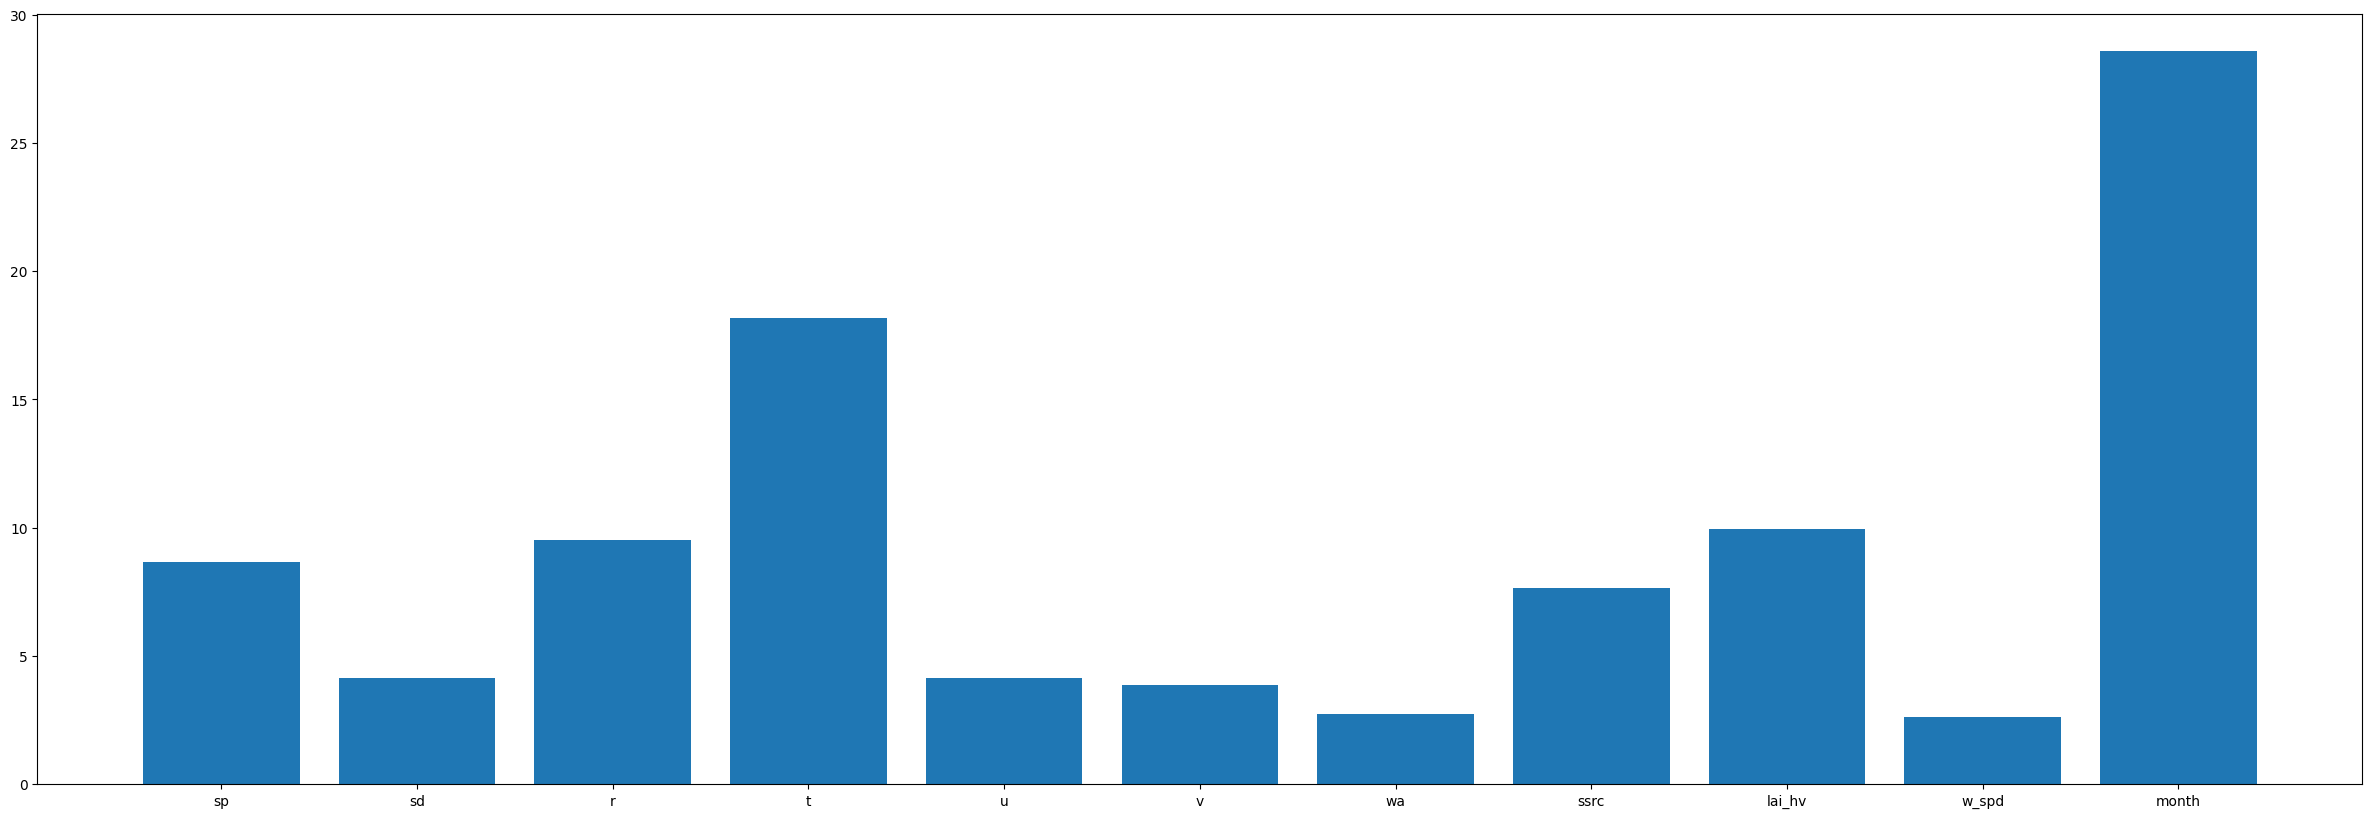

In [909]:
plt.figure(figsize=(30,10))
plt.bar(features_joint.columns,height=CAT_model.feature_importances_)

plt.show()

In [924]:
best_params_RF = trial.params

In [925]:
best_params_RF

{'max_depth': 10, 'criterion': 'poisson', 'n_estimators': 63}

In [926]:
RF_model = RandomForestRegressor(**best_params_RF)
RF_model.fit(feat_train_scaled, 
                  target_train )
    
predictions_RF = RF_model.predict(scaler.transform(feat_test))

C:\Users\Alisa\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


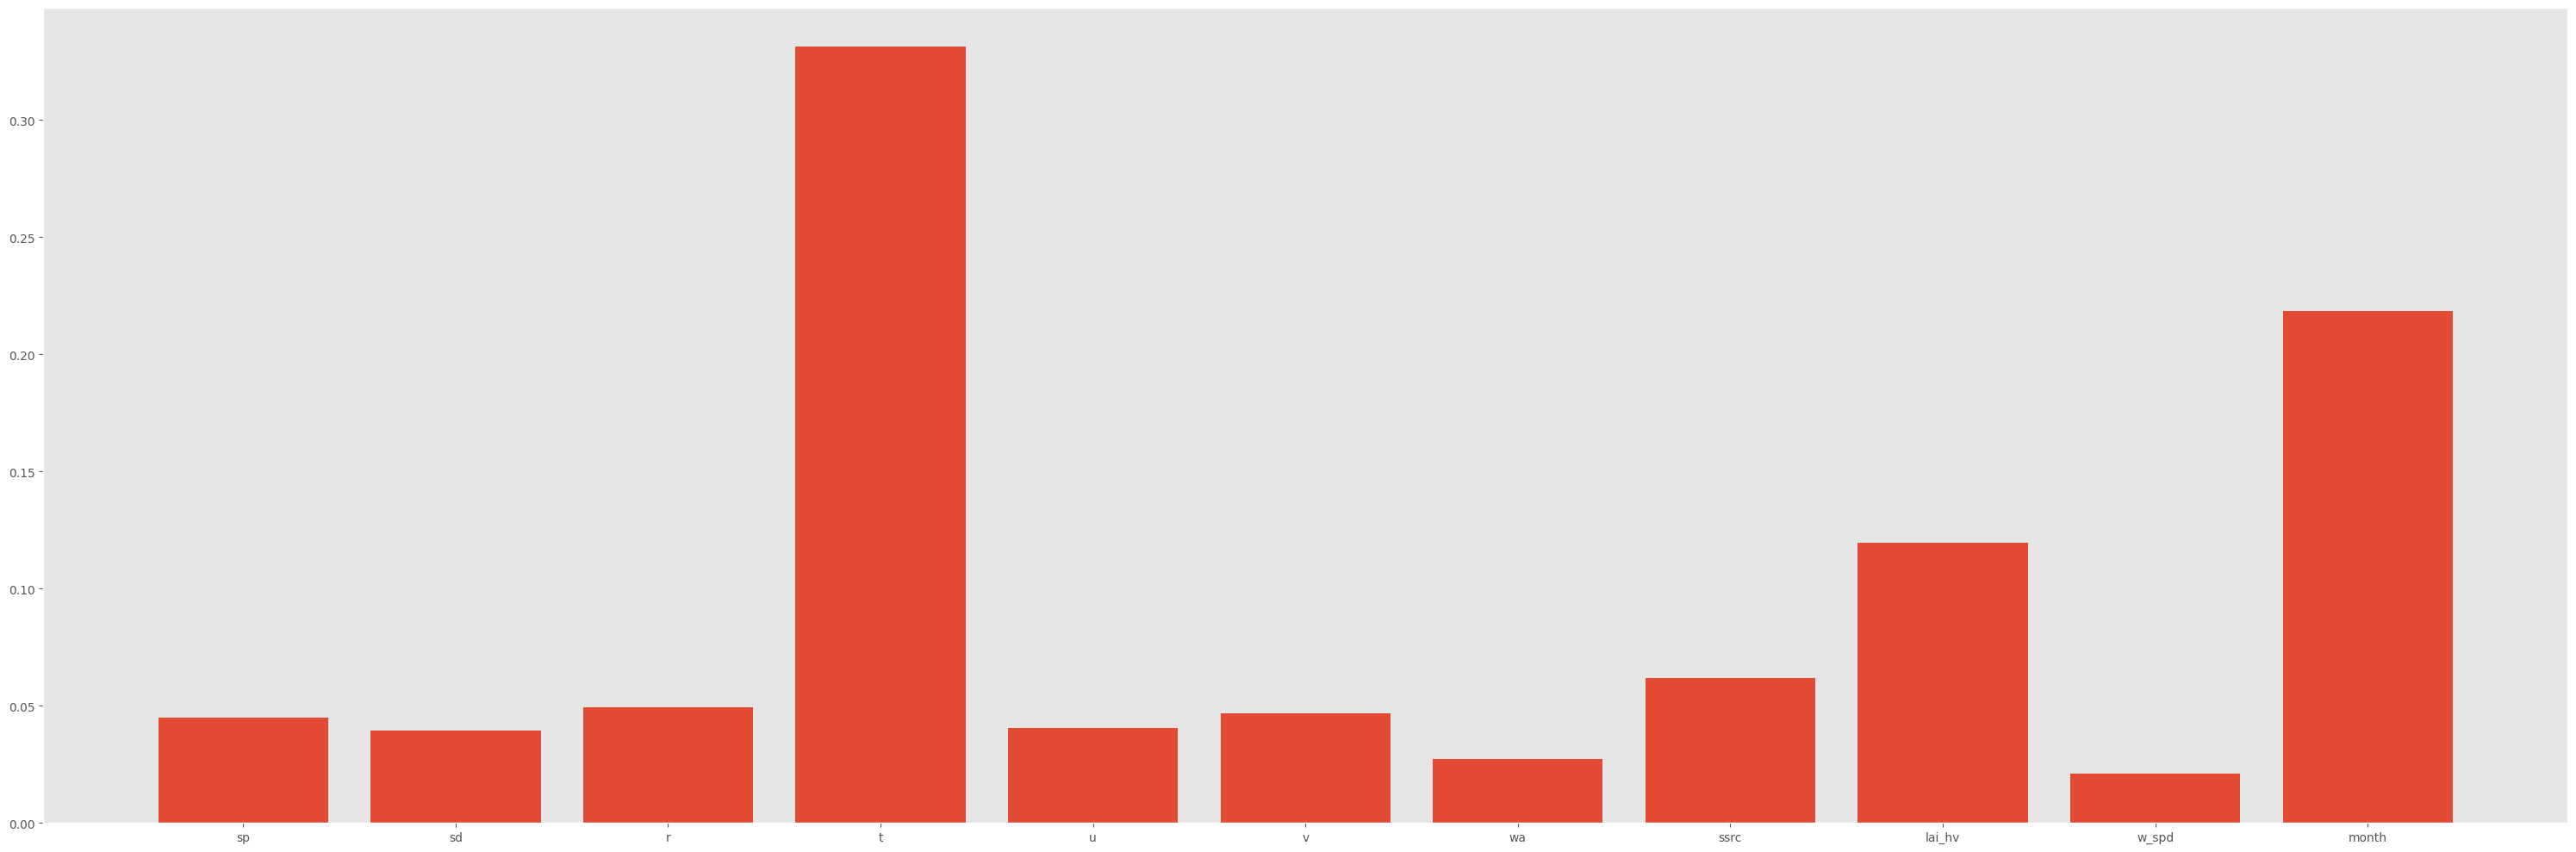

In [1011]:
plt.figure(figsize=(30,10))
plt.bar(features_joint.columns,height=RF_model.feature_importances_)

plt.show()

In [1097]:
prediction_CAT =  CAT_model.predict(scaler.transform(feat_test))#_test))#_test RF_model
prediction_RF =  RF_model.predict(scaler.transform(feat_test))#_test))#_test RF_model

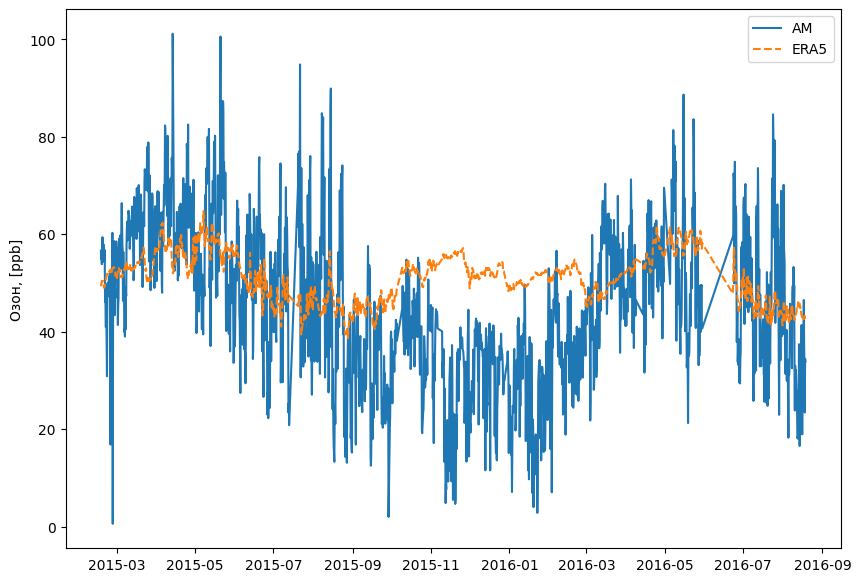

In [1360]:
#plot train timeseries

condition = target_joint.index.isin(list(target_test.index))
plt.figure(figsize=(10,7))
plt.plot(target_joint.index[~condition],target_joint[~condition])

plt.plot(target_joint.index[~condition],features_o3[~condition],'--')
plt.ylabel('Озон, [ppb]')
plt.legend(['AM','ERA5'])
plt.savefig('D:/Ozon_ML/График_1.tiff',dpi=1000)

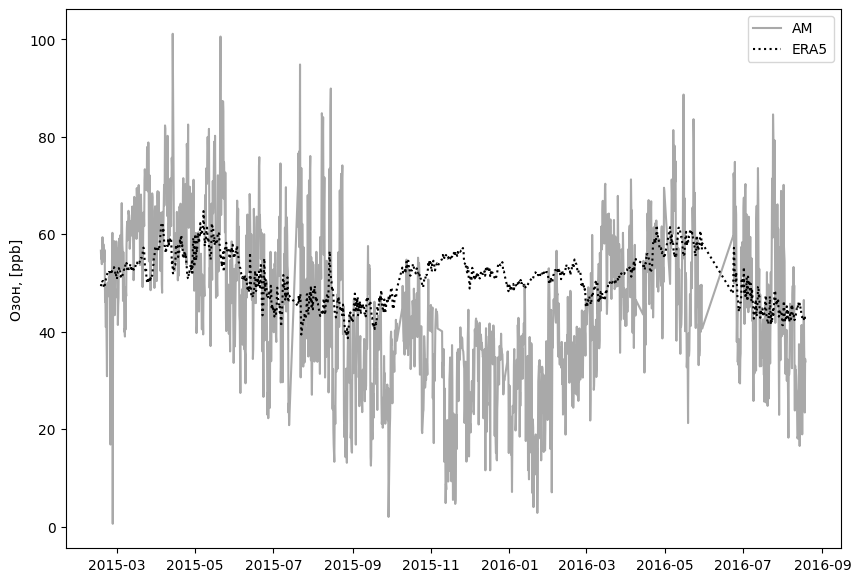

In [1364]:
#train timeseries in grey scale

condition = target_joint.index.isin(list(target_test.index))
plt.figure(figsize=(10,7))
plt.plot(target_joint.index[~condition],target_joint[~condition], color='darkgrey')

plt.plot(target_joint.index[~condition],features_o3[~condition],linestyle='dotted',color='black')
plt.ylabel('Озон, [ppb]')
plt.legend(['AM','ERA5'])
plt.savefig('D:/Ozon_ML/График_1_gray.tiff',dpi=1000)

In [1138]:
#features sorted 

CAT_feat = pd.Series(CAT_model.feature_importances_,index=features_joint.columns).sort_values(ascending=False)
RF_feat = pd.Series(RF_model.feature_importances_,index=features_joint.columns).sort_values(ascending=False) * 100

month     28.591736
t         18.176120
lai_hv     9.928683
r          9.508798
sp         8.672586
ssrc       7.653161
sd         4.137118
u          4.131357
v          3.875397
wa         2.723790
w_spd      2.601254
t         33.135802
month     21.834043
lai_hv    11.943724
ssrc       6.189183
r          4.923264
v          4.663643
sp         4.484485
u          4.061593
sd         3.933072
wa         2.742392
w_spd      2.088799
dtype: float64

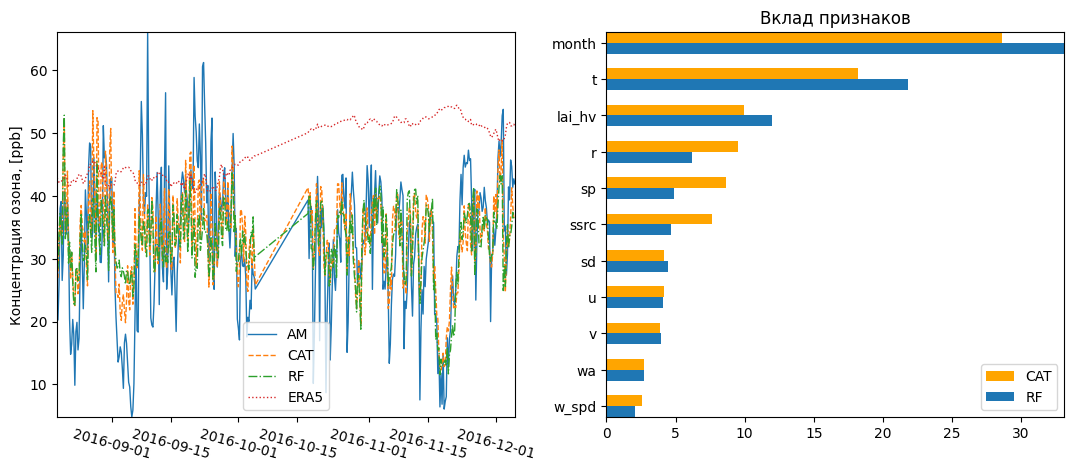

In [1359]:
#plot test prediction and feature importances

plt.figure(figsize=(13,5))


ax=plt.subplot(1,2,2)
ax.margins(0)

x = np.arange(RF_feat.shape[0])
width=0.3

#plt.figure(figsize=(2,1))
matplotlib.rcdefaults()

rects1 = ax.barh(x - width/2, CAT_feat, width, label='CAT',color='orange')
rects2 = ax.barh(x + width/2, RF_feat, width, label='RF')
ax.set_yticks(np.arange(RF_feat.shape[0]), labels=CAT_feat.index)
ax.invert_yaxis()
ax.set_title('Вклад признаков')
#ax.set_ylabel(CAT_feat.index.values)
#ax.set_xticklabels(cat_par)
ax.legend()



ax=plt.subplot(1,2,1)
matplotlib.rcdefaults()

ax.margins(0)
ax.patch.set_facecolor('white')
#plt.figure(figsize=(15,5))
o3_pred = target_joint[target_joint.index.isin(list(target_test.index))]
plt.plot(target_test.index,o3_pred,linewidth=1,label='AM')
plt.plot(target_test.index,prediction_CAT,linewidth=1,label='CAT',linestyle='--')
plt.plot(target_test.index,prediction_RF,linewidth=1,label='RF',linestyle='-.') 
plt.plot(target_test.index,features_o3[features_o3.index.isin(list(target_test.index))],linewidth=1,label='ERA5',linestyle='dotted')
plt.legend(['AM','CAT','RF','ERA5'])
plt.ylabel('Концентрация озона, [ppb]')
#ax.Tick(axes, size=None, width=None, color=None, tickdir=45, labelsize=2)


# ax=plt.subplot(2,2,3)
# matplotlib.rcdefaults()

ax.margins(0)
plt.xticks(rotation=-15)


plt.savefig('D:/Ozon_ML/График_2.tiff',dpi=1000)
plt.show()

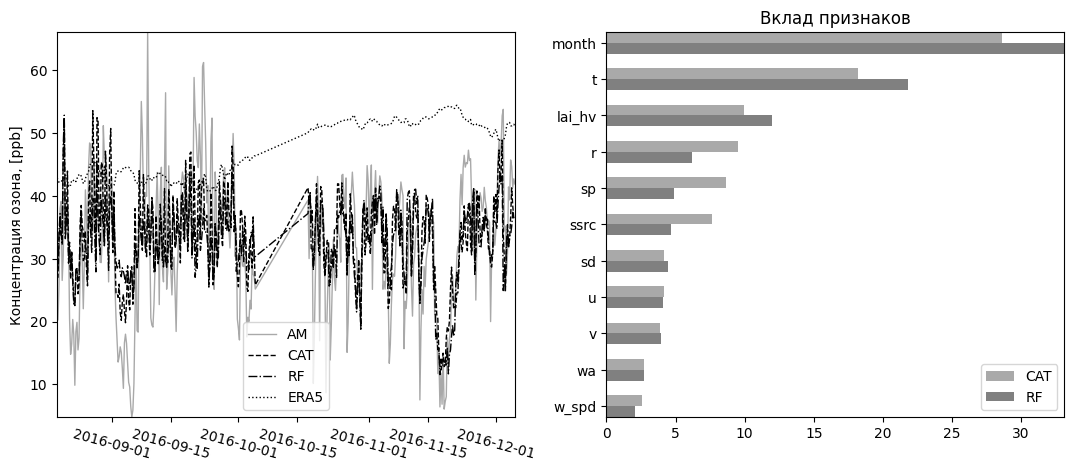

In [1366]:
#in grey scale

plt.figure(figsize=(13,5))


ax=plt.subplot(1,2,2)
ax.margins(0)

x = np.arange(RF_feat.shape[0])
width=0.3

#plt.figure(figsize=(2,1))
matplotlib.rcdefaults()

rects1 = ax.barh(x - width/2, CAT_feat, width, label='CAT',color='darkgrey')
rects2 = ax.barh(x + width/2, RF_feat, width, label='RF',color='grey')
ax.set_yticks(np.arange(RF_feat.shape[0]), labels=CAT_feat.index)
ax.invert_yaxis()
ax.set_title('Вклад признаков')
#ax.set_ylabel(CAT_feat.index.values)
#ax.set_xticklabels(cat_par)
ax.legend()



ax=plt.subplot(1,2,1)
matplotlib.rcdefaults()

ax.margins(0)
ax.patch.set_facecolor('white')
#plt.figure(figsize=(15,5))
o3_pred = target_joint[target_joint.index.isin(list(target_test.index))]
plt.plot(target_test.index,o3_pred,linewidth=1,label='AM',color='darkgrey')
plt.plot(target_test.index,prediction_CAT,linewidth=1,label='CAT',linestyle='--',color='black')
plt.plot(target_test.index,prediction_RF,linewidth=1,label='RF',linestyle='-.',color='black') 
plt.plot(target_test.index,features_o3[features_o3.index.isin(list(target_test.index))],linewidth=1,label='ERA5',linestyle='dotted',color='black')
plt.legend(['AM','CAT','RF','ERA5'])
plt.ylabel('Концентрация озона, [ppb]')
#ax.Tick(axes, size=None, width=None, color=None, tickdir=45, labelsize=2)


# ax=plt.subplot(2,2,3)
# matplotlib.rcdefaults()

ax.margins(0)
plt.xticks(rotation=-15)


plt.savefig('D:/Ozon_ML/График_2gray.tiff',dpi=1000)
plt.show()

In [ ]:
#comparison of mothly resample
active_monthly = target_joint.resample('M').mean()
RF_ozone_monthly = pd.Series(prediction_RF,index=target_joint.index).resample('M').mean()
CAT_ozone_monthly = pd.Series(prediction_CAT,index=target_joint.index).resample('M').mean()
ERA5_ozone_monthly = pd.Series(features_joint['o3_ppb'],index=ppb6H.target_joint).resample('M').mean()

In [ ]:
#plt.plot(range(1,13),active_monthly)
plt.scatter(range(1,13),1-RF_ozone_monthly / active_monthly)
plt.scatter(range(1,13),1- CAT_ozone_monthly / active_monthly)
plt.scatter(range(1,13),1 - ERA5_ozone_monthly / active_monthly)
plt.legend(['RF','CAT','ERA5'])#'active',
plt.show()

In [1351]:
#MAPE

print('CAT MAPE', mean_absolute_percentage_error(target_test, prediction_CAT))#_test
print('RF MAPE', mean_absolute_percentage_error(target_test, prediction_RF))
print('ERA MSE', mean_absolute_percentage_error(target_test, features_o3.iloc[2000:]['o3_ppb']))

CAT MAPE 0.2851784078738836
RF MAPE 0.29940035167163565
ERA MSE 0.816468393151761


In [1352]:
#MAE

print('CAT MAE', mean_absolute_error(target_test, prediction_CAT))#_test
print('RF MAE', mean_absolute_error(target_test, prediction_RF))
print('ERA MSE', mean_absolute_error(target_test, features_o3.iloc[2000:]['o3_ppb']))

CAT MAE 6.663003262634916
RF MAE 7.065339904713877
ERA MSE 16.37741817772491


In [1353]:
#MSE

print('CAT MSE', mean_squared_error(target_test, prediction_CAT))#_test
print('RF MSE', mean_squared_error(target_test, prediction_RF))
print('ERA MSE', mean_squared_error(target_test, features_o3.iloc[2000:]['o3_ppb']))

CAT MSE 69.45514310481504
RF MSE 78.76718619276606
ERA MSE 383.50478483279005


In [ ]:
#JOIN 2015 and try the model for 2015 prediction

In [818]:
data = pd.read_csv('D:/Ozon_ML/Listv_2015_ozon.txt',
                        sep='	',
                        skip_blank_lines=True, 
                        names=['date','time','ppb']
                      )# parse_dates=[0,1]

<class 'pandas.core.frame.DataFrame'>
Index: 86853 entries, 0 to 86857
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    86833 non-null  datetime64[ns]
 1   time    86833 non-null  object        
 2   ppb     85754 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86853 entries, 2015-02-16 14:29:00 to 2015-12-31 23:57:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppb     85754 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1210 entries, 2015-02-16 12:00:00 to 2015-12-31 18:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppb     1210 non-null   float64
dtypes: float64(1)
memory usage: 18.9 KB
ppb6H No

<Axes: xlabel='date'>

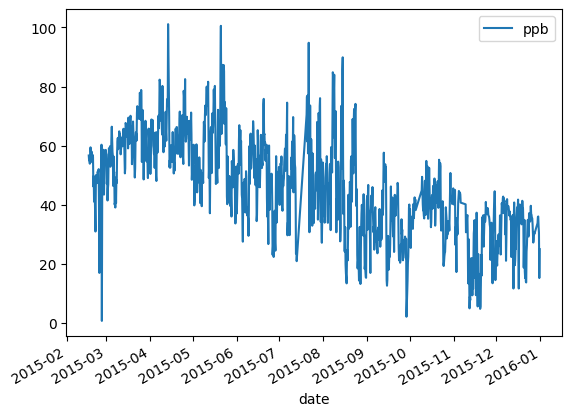

In [819]:
data['date'] = data['date'].astype('str').apply(lambda x: x[:-3])
data['date'] = data['date'].astype('str').apply(lambda x: x.replace('.','/'))
data['date'] = data['date'].astype('str').apply(lambda x: x+'/2015')
data['date'] = data['date'] + ' ' + data['time']
data['date'] = pd.to_datetime(data['date'],format='%m/%d/%Y %H:%M')
data = data.drop(index=[53,106,354,541,2385])
data['ppb'] = data['ppb'].astype('float')
print(data.info())

ppb=pd.DataFrame(data['ppb']).set_index(data['date'])
print(ppb.info())
# AM_times =pd.DataFrame(pd.date_range(data.iloc[0]['date'],data.iloc[-1]['date'],freq='5min'),columns=['date'])
# ppb_gridded = AM_times.merge(ppb,on='date',how='outer').fillna(ppb_gridded[~ppb_gridded.isna()].mean())
# ppb_gridded.info()
# ppb6H = ppb_gridded.set_index('date').resample('6H').mean()
ppb6H = ppb.resample('6H').mean().dropna()
print('ppb6H' ,ppb6H.info())
ppb6H.plot()


In [820]:
file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2015_pres.nc','r')

print(file2read.variables.keys())

o3 = np.array(file2read.variables['o3'])[:,0,0]

r = np.array(file2read.variables['r'])[:,0,0]

t = np.array(file2read.variables['t'])[:,0,0]

u = np.array(file2read.variables['u'])[:,0,0]

v = np.array(file2read.variables['v'])[:,0,0]

o3_ppb = 28.9644 / 47.9982 * 1e9 * o3


dict_keys(['longitude', 'latitude', 'time', 'o3', 'r', 't', 'u', 'v'])


In [821]:
len(o3_ppb)

1460

In [822]:
file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2015_surf.nc','r')

print(file2read.variables.keys())
sp=np.array(file2read.variables['sp'])

sp = sp[:,0,0]

sd=np.array(file2read.variables['sd'])
sd = sd[:,0,0]

ssrc = np.array(file2read.variables['ssrc'])[:,0,0]
fdir = np.array(file2read.variables['fdir'])[:,0,0]

file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka2015_veg.nc','r')
print(file2read.variables.keys())

lai_hv = np.array(file2read.variables['lai_hv'])[:,0,0]

lai_lv = np.array(file2read.variables['lai_lv'])[:,0,0]

dict_keys(['longitude', 'latitude', 'time', 'ssrc', 'fdir', 'sp', 'sd'])
dict_keys(['longitude', 'latitude', 'time', 'lai_lv', 'lai_hv'])


In [823]:
# ppb6H.loc[ppb6H['ppb'].isna(),'ppb'] = ppb6H.loc[~ppb6H['ppb'].isna(),'ppb'].mean()

In [824]:
era5_time = np.array(file2read.variables['time'])
time = pd.to_datetime("1900-01-01")+pd.to_timedelta(era5_time, unit="H")
hours = era5_time

In [825]:
hours00 = np.zeros(len(v))
hours06 = np.zeros(len(v))
hours12 = np.zeros(len(v))
hours18 = np.zeros(len(v))
for i in range(len(v)):
    if i%4==0: hours00[i] = 1
    if (i-1)%4==0: hours06[i] = 1
    if (i-2)%4==0: hours12[i] = 1
    if (i-3)%4==0: hours18[i] = 1

In [826]:
time = pd.to_datetime("1900-01-01")+pd.to_timedelta(era5_time, unit="H")
hours = era5_time

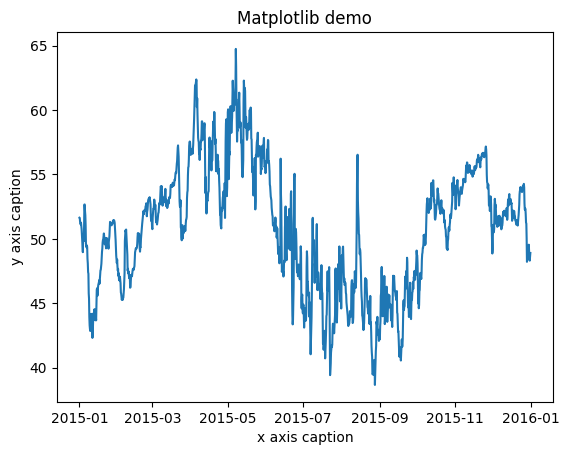

In [827]:
plt.title("Matplotlib demo") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(time, o3_ppb) 
plt.show()

ppb4H vs o3_ppb

In [828]:
#select the records in measurement data
o3_ppb = o3_ppb[time.isin(ppb6H.index)]
sp = sp[time.isin(ppb6H.index)]
sd = sd[time.isin(ppb6H.index)]
#cc = cc[time.isin(ppb6H.index)]
r = r[time.isin(ppb6H.index)]
t = t[time.isin(ppb6H.index)]
u = u[time.isin(ppb6H.index)]
v = v[time.isin(ppb6H.index)]
hours = hours[time.isin(ppb6H.index)]
ssrc = ssrc[time.isin(ppb6H.index)]
fdir = fdir[time.isin(ppb6H.index)]
# hours00 = hours00[time.isin(ppb6H.index)]
# hours06 = hours06[time.isin(ppb6H.index)]
# hours12 = hours12[time.isin(ppb6H.index)]
#hours18 = hours18[time.isin(ppb6H.index)]
lai_hv = lai_hv[time.isin(ppb6H.index)]
lai_lv = lai_lv[time.isin(ppb6H.index)]

In [829]:
#wind angle
wa = u/v

#
sd_ind = np.zeros(len(sd))
sd_ind[sd>0] = 1

In [830]:
wtg = np.zeros(len(wa))
wtg[(abs(wa)<0.5)&(u<0)&(v<0)] = 1

In [831]:
features = pd.DataFrame(o3_ppb)
features['sp'] = sp
features['sd'] = sd
#features['cc'] = cc
features['r'] = r
features['t'] = t
features['u'] = u
features['v'] = v
features['wa'] = wa
#features['sd_ind'] = sd_ind
features['o3_ppb'] = o3_ppb
# features['hours00'] = hours00
# features['hours06'] = hours06
# features['hours12'] = hours12
# features['hours18'] = hours18
#features['hours_delta'] = abs(pd.Series(hours).shift(1).bfill()-pd.Series(hours))#hours
features['ssrc'] = ssrc
#features['lai_lv'] = lai_lv
features['lai_hv'] = lai_hv
#features['fdir'] = fdir
features['w_spd'] = (u**2 +v**2)**0.5
#features['wtg'] = wtg
features['month'] = pd.Series(ppb6H.index).dt.month

In [648]:
#features['week'] = pd.Series(ppb6H.index).dt.strftime('%U')

In [832]:
features = features.drop(0,axis=1)
target = ppb6H#-ppb6H.shift(2).bfill()

features_2015 = features
target_2015 = ppb6H


## Passive comparison


In [549]:
data_2016_passive = pd.read_csv('D:/Ozon_ML/Listv_2016_ozon_passive.txt', sep='\t',
                   names=['date_start','hours_start','minutes_start','date_end','hours_end','minutes_end','ppb'])

In [550]:
act_to_pas_2016 = []

for i in range(data_2016_passive.shape[0]):
    act_to_pas_2016.append(oozone_1516.iloc[(oozone_1516.index>=data_2016_passive.iloc[i]['date_start'])&(oozone_1516.index<data_2016_passive.iloc[i]['date_end'])]['ppb'].mean())

NameError: name 'oozone_1516' is not defined

In [ ]:
CAT_to_pas_2016 = []
prediction_CAT = pd.DataFrame(prediction_CAT,index=target.index)
for i in range(data_2016_passive.shape[0]):
    CAT_to_pas_2016.append(prediction_CAT.iloc[(prediction_CAT.index>=data_2016_passive.iloc[i]['date_start'])&(prediction_CAT.index<data_2016_passive.iloc[i]['date_end'])].mean())

In [ ]:
RF_to_pas_2016 = []
prediction_RF = pd.DataFrame(prediction_RF,index=target.index)
for i in range(data_2016_passive.shape[0]):
    RF_to_pas_2016.append(prediction_RF.iloc[(prediction_RF.index>=data_2016_passive.iloc[i]['date_start'])&(prediction_RF.index<data_2016_passive.iloc[i]['date_end'])].mean())

In [ ]:
o3_ERA5_to_pas_2016 = []
ERA5 = pd.DataFrame(o3_ppb,index=target.index)
for i in range(data_2016_passive.shape[0]):
    o3_ERA5_to_pas_2016.append(ERA5.iloc[(ERA5.index>=data_2016_passive.iloc[i]['date_start'])&(ERA5.index<data_2016_passive.iloc[i]['date_end'])].mean())

In [ ]:
prediction_CAT.index

In [ ]:
ppb.iloc[(ppb.index>=data_2016_passive.iloc[4]['date_start'])&(ppb.index<data_2016_passive.iloc[4]['date_end'])]

In [ ]:
CAT_to_pas_2016

In [ ]:
plt.scatter(data_2016_passive['date_start'],np.array(act_to_pas_2016))
plt.plot(data_2016_passive['date_start'],np.array(act_to_pas_2016))
plt.scatter(data_2016_passive['date_start'],data_2016_passive['ppb'])
plt.scatter(data_2016_passive['date_start'],np.array(CAT_to_pas_2016))
plt.scatter(data_2016_passive['date_start'],np.array(RF_to_pas_2016))
plt.scatter(data_2016_passive['date_start'],np.array(o3_ERA5_to_pas_2016))
plt.legend(['Active','Passive','CAT','RF','ERA5'])
plt.show

## Predict for years 2017 - 2022

In [1298]:
file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka17_22surf.nc','r')
print(file2read.variables.keys())
sp=np.array(file2read.variables['sp'])

sp = sp[:,0,0]

sd=np.array(file2read.variables['sd'])
sd = sd[:,0,0]

ssrc = np.array(file2read.variables['ssrc'])[:,0,0]

lai_hv = np.array(file2read.variables['lai_hv'])[:,0,0]

file2read = netCDF4.Dataset('D:/Ozon_ML/Listvyanka17_22pres.nc','r')

print(file2read.variables.keys())

o3 = np.array(file2read.variables['o3'])[:,0,0]

r = np.array(file2read.variables['r'])[:,0,0]

t = np.array(file2read.variables['t'])[:,0,0]

u = np.array(file2read.variables['u'])[:,0,0]

v = np.array(file2read.variables['v'])[:,0,0]

o3_ppb = 28.9644 / 47.9982 * 1e9 * o3

o3_ppb[o3_ppb<0] = o3_ppb[o3_ppb>0].mean()
wa = u/v



era5_time = np.array(file2read.variables['time'])

time = pd.to_datetime("1900-01-01")+pd.to_timedelta(era5_time, unit="H")

features = pd.DataFrame(o3_ppb)
features['sp'] = sp
features['sd'] = sd
#features['cc'] = cc
features['r'] = r
features['t'] = t
features['u'] = u
features['v'] = v
features['wa'] = wa
#features['sd_ind'] = sd_ind
#features['o3_ppb'] = o3_ppb
# features['hours00'] = hours00
# features['hours06'] = hours06
# features['hours12'] = hours12
# features['hours18'] = hours18
#features['hours_delta'] = abs(pd.Series(hours).shift(1).bfill()-pd.Series(hours))#hours
features['ssrc'] = ssrc
#features['lai_lv'] = lai_lv
features['lai_hv'] = lai_hv
#features['fdir'] = fdir
features['w_spd'] = (u**2 +v**2)**0.5
#features['wtg'] = wtg
features['month'] = time.month
features = features.drop(0,axis=1)

dict_keys(['longitude', 'latitude', 'time', 'lai_hv', 'ssrc', 'sp', 'sd'])
dict_keys(['longitude', 'latitude', 'time', 'o3', 'r', 't', 'u', 'v'])


In [1299]:
features

,sp,sd,r,t,u,v,wa,ssrc,lai_hv,w_spd,month
0,94233.526449,0.009642,100.483207,266.996226,-0.986162,-0.583452,1.690219,0.000000,1.973357,1.145833,1
1,93953.251133,0.009685,72.563404,267.193871,-0.733887,0.136447,-5.378552,486904.032838,1.974106,0.746464,1
2,93824.554518,0.009680,93.155323,267.228380,-1.679919,-0.183147,9.172499,0.000000,1.974629,1.689873,1
3,93502.510310,0.009681,94.273573,266.992043,-2.125126,-0.587450,3.617542,0.000000,1.975378,2.204827,1
4,92994.624800,0.009843,84.329347,265.404610,-2.771581,-0.410287,6.755230,0.000000,1.975976,2.801785,1
...,...,...,...,...,...,...,...,...,...,...,...
8759,95539.863672,0.007089,97.991453,257.988224,1.560381,-1.915304,-0.814691,0.000000,1.970364,2.470461,12
8760,95719.772579,0.008014,94.352580,257.245749,0.981869,-2.061483,-0.476293,0.000000,1.970813,2.283370,12
8761,95845.684601,0.008197,84.241224,256.454124,1.187989,-2.233149,-0.531979,471675.021256,1.971561,2.529481,12
8762,96079.348256,0.008198,95.742797,254.737020,1.158175,-2.160684,-0.536022,0.000000,1.972160,2.451515,12


In [1300]:
prediction2017_2022 = CAT_model.predict(scaler.transform(features))

prediction2017_2022_monthly = pd.Series(prediction2017_2022, index=time).resample('m').mean()

In [1301]:
ERA5_monthly = pd.Series(o3_ppb,index=time).resample('m').mean()

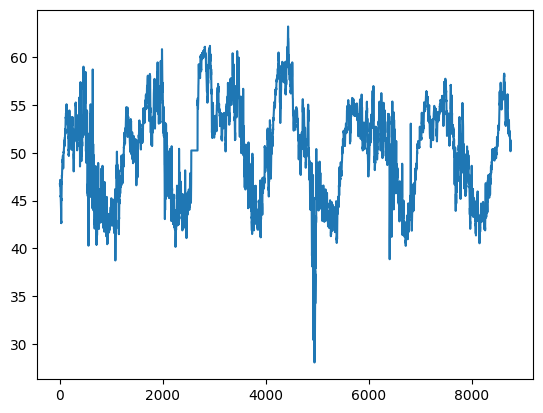

In [1302]:
plt.plot(o3_ppb)
plt.show()

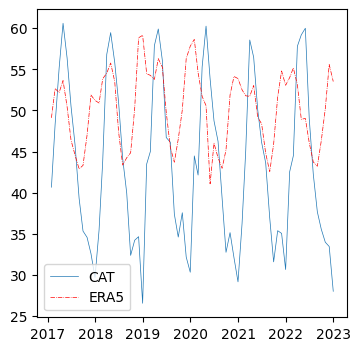

In [1358]:
#plt.scatter(prediction2017_2022_monthly.index,prediction2017_2022_monthly,label='CAT')
plt.figure(figsize=(4,4))
plt.plot(prediction2017_2022_monthly.index,prediction2017_2022_monthly,label='CAT',linestyle='-',linewidth=0.5)
#plt.scatter(ERA5_monthly.index,ERA5_monthly,label='ERA5')
plt.plot(ERA5_monthly.index,ERA5_monthly,label='ERA5',linestyle='-.',color='red',linewidth=0.5)
plt.legend()

plt.savefig('D:/Ozon_ML/График_3.tiff',dpi=1000)
#plt.imsave('D:/Ozon_ML/График_3_grey.tiff',dpi=1000,cmap='grey')
plt.show()

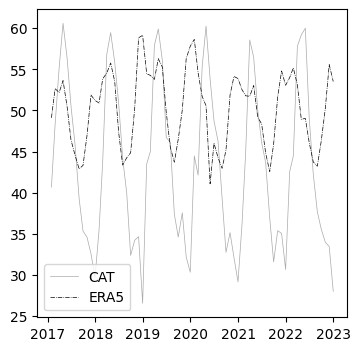

In [1367]:
#plt.scatter(prediction2017_2022_monthly.index,prediction2017_2022_monthly,label='CAT')
plt.figure(figsize=(4,4))
plt.plot(prediction2017_2022_monthly.index,prediction2017_2022_monthly,label='CAT',linestyle='-',linewidth=0.5,color='darkgrey')
#plt.scatter(ERA5_monthly.index,ERA5_monthly,label='ERA5')
plt.plot(ERA5_monthly.index,ERA5_monthly,label='ERA5',linestyle='-.',color='black',linewidth=0.5)
plt.legend()

plt.savefig('D:/Ozon_ML/График_3_grey.tiff',dpi=1000)
#plt.imsave('D:/Ozon_ML/График_3_grey.tiff',dpi=1000,cmap='grey')
plt.show()